# 📄 Paper Image Generation

This notebook generates high-quality figures for research paper publication, showing:

## 🎯 Figure Types
1. **Augmented Images**: Before/after comparison of real images with synthetic objects added
2. **Synthetic Images**: Examples of fully synthetic images generated using domain randomization

## 📊 Output Specifications
- **High Resolution**: 300 DPI for publication quality
- **Professional Layout**: Clean, academic presentation
- **Clear Annotations**: Bounding boxes and class labels
- **Comparative Format**: Side-by-side before/after views

In [1]:
# =====================================================
# IMPORTS AND CONFIGURATION
# =====================================================

import os
import json
import cv2
import numpy as np
import yaml
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
from tqdm import tqdm

# Set random seed for reproducibility
RANDOM_SEED = 47
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Paths
BASE_DIR = Path('/home/andrea/work/AI-waste-detection/')
K_FOLD_CV_DIR = BASE_DIR / 'datasets/k_fold_cv'
OBJECT_BANK_DIR = BASE_DIR / 'datasets/object_bank_for_balancing'
TACO_DIR = BASE_DIR / 'datasets/taco_official'

# Paper figure settings
FIGURE_DPI = 300
FIGURE_SIZE = (16, 16)  # Larger figure size
CLASS_NAMES = ['glass', 'metal', 'organic', 'paper', 'plastic']
CLASS_COLORS = {
    0: '#FF6B6B',  # glass - red
    1: '#4ECDC4',  # metal - teal
    2: '#45B7D1',  # organic - blue
    3: '#96CEB4',  # paper - green
    4: '#FFEAA7'   # plastic - yellow
}

# Image generation parameters (matching training set)
IMAGE_SIZE = (640, 640)
OBJECTS_PER_IMAGE_RANGE = (2, 7)  # Match training parameters
SCALE_RANGE = (0.2, 0.7)  # Match training parameters
ROTATION_RANGE = (-20, 20)  # Match training parameters
OVERLAP_THRESHOLD = 0.05

print("🎨 Paper Image Generation Setup Complete")
print(f"📁 K-Fold Dataset: {K_FOLD_CV_DIR}")
print(f"🏦 Object Bank: {OBJECT_BANK_DIR}")
print(f"📊 Figure DPI: {FIGURE_DPI}")
print(f"🎯 Classes: {CLASS_NAMES}")

🎨 Paper Image Generation Setup Complete
📁 K-Fold Dataset: /home/andrea/work/AI-waste-detection/datasets/k_fold_cv
🏦 Object Bank: /home/andrea/work/AI-waste-detection/datasets/object_bank_for_balancing
📊 Figure DPI: 300
🎯 Classes: ['glass', 'metal', 'organic', 'paper', 'plastic']


In [2]:
# =====================================================
# UTILITY FUNCTIONS
# =====================================================

def load_yolo_annotations(label_path):
    """Load YOLO format annotations from a label file."""
    annotations = []
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    cx, cy, w, h = map(float, parts[1:5])
                    annotations.append({
                        'class_id': class_id,
                        'cx': cx,
                        'cy': cy,
                        'w': w,
                        'h': h
                    })
    return annotations

def yolo_to_bbox(annotation, img_width, img_height):
    """Convert YOLO format to bounding box coordinates."""
    cx, cy, w, h = annotation['cx'], annotation['cy'], annotation['w'], annotation['h']
    
    x1 = int((cx - w/2) * img_width)
    y1 = int((cy - h/2) * img_height)
    x2 = int((cx + w/2) * img_width)
    y2 = int((cy + h/2) * img_height)
    
    return x1, y1, x2, y2

def bbox_to_yolo(x1, y1, x2, y2, img_width, img_height):
    """Convert bounding box coordinates to YOLO format."""
    cx = (x1 + x2) / 2 / img_width
    cy = (y1 + y2) / 2 / img_height
    w = (x2 - x1) / img_width
    h = (y2 - y1) / img_height
    return cx, cy, w, h

def draw_bboxes_on_image(image, annotations, class_names, colors):
    """Draw bounding boxes and labels on an image."""
    img_height, img_width = image.shape[:2]
    img_copy = image.copy()
    
    for ann in annotations:
        class_id = ann['class_id']
        if class_id >= len(class_names):
            continue
            
        x1, y1, x2, y2 = yolo_to_bbox(ann, img_width, img_height)
        
        # Get color
        color_hex = colors.get(class_id, '#FFFFFF')
        color_rgb = tuple(int(color_hex[i:i+2], 16) for i in (1, 3, 5))
        color_bgr = (color_rgb[2], color_rgb[1], color_rgb[0])  # Convert to BGR
        
        # Draw bounding box
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color_bgr, 2)
        
        # Draw label
        label = class_names[class_id]
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
        cv2.rectangle(img_copy, (x1, y1 - label_size[1] - 10), 
                     (x1 + label_size[0], y1), color_bgr, -1)
        cv2.putText(img_copy, label, (x1, y1 - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return img_copy

def load_object_bank():
    """Load object bank for synthetic generation."""
    object_bank = defaultdict(list)
    
    if not OBJECT_BANK_DIR.exists():
        print("⚠️ Object bank directory not found")
        return object_bank
    
    for class_dir in OBJECT_BANK_DIR.iterdir():
        if class_dir.is_dir() and class_dir.name in CLASS_NAMES:
            for obj_file in class_dir.glob('*.png'):
                object_bank[class_dir.name].append(obj_file)
    
    print(f"📦 Object bank loaded:")
    for class_name, objects in object_bank.items():
        print(f"   {class_name}: {len(objects)} objects")
    
    return object_bank

print("✅ Utility functions loaded")

✅ Utility functions loaded


In [3]:
# =====================================================
# AUGMENTED IMAGE GENERATION FUNCTIONS
# =====================================================

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes in (x1, y1, x2, y2) format."""
    x1_i = max(box1[0], box2[0])
    y1_i = max(box1[1], box2[1])
    x2_i = min(box1[2], box2[2])
    y2_i = min(box1[3], box2[3])
    
    inter_area = max(0, x2_i - x1_i) * max(0, y2_i - y1_i)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0

def add_synthetic_objects_to_image(image, existing_annotations, object_bank, num_objects=2):
    """Add synthetic objects to an existing image while avoiding overlaps."""
    img_height, img_width = image.shape[:2]
    augmented_image = image.copy()
    new_annotations = existing_annotations.copy()
    
    # Convert existing annotations to bounding boxes
    existing_bboxes = []
    for ann in existing_annotations:
        x1, y1, x2, y2 = yolo_to_bbox(ann, img_width, img_height)
        existing_bboxes.append((x1, y1, x2, y2))
    
    # Add new objects
    objects_added = 0
    attempts = 0
    max_attempts = 50
    
    while objects_added < num_objects and attempts < max_attempts:
        attempts += 1
        
        # Select random class and object
        available_classes = [name for name in CLASS_NAMES if object_bank[name]]
        if not available_classes:
            break
            
        class_name = random.choice(available_classes)
        class_id = CLASS_NAMES.index(class_name)
        obj_path = random.choice(object_bank[class_name])
        
        # Load and transform object
        obj_img = Image.open(obj_path)
        
        # Random transformations
        scale = random.uniform(*SCALE_RANGE)
        new_size = (int(img_width * scale), int(img_height * scale))
        obj_img.thumbnail(new_size, Image.Resampling.LANCZOS)
        
        rotation = random.uniform(*ROTATION_RANGE)
        obj_img = obj_img.rotate(rotation, expand=True, resample=Image.Resampling.BICUBIC)
        
        # Try to place the object
        for _ in range(20):  # 20 placement attempts
            pos_x = random.randint(0, max(1, img_width - obj_img.width))
            pos_y = random.randint(0, max(1, img_height - obj_img.height))
            
            new_bbox = (pos_x, pos_y, pos_x + obj_img.width, pos_y + obj_img.height)
            
            # Check for overlaps
            is_overlapping = any(calculate_iou(new_bbox, bbox) > OVERLAP_THRESHOLD 
                               for bbox in existing_bboxes)
            
            if not is_overlapping:
                # Convert to PIL for pasting
                pil_image = Image.fromarray(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
                pil_image.paste(obj_img, (pos_x, pos_y), obj_img)
                augmented_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
                
                # Add annotation
                cx, cy, w, h = bbox_to_yolo(new_bbox[0], new_bbox[1], new_bbox[2], new_bbox[3], 
                                          img_width, img_height)
                new_annotations.append({
                    'class_id': class_id,
                    'cx': cx,
                    'cy': cy,
                    'w': w,
                    'h': h
                })
                
                existing_bboxes.append(new_bbox)
                objects_added += 1
                break
    
    return augmented_image, new_annotations

def find_suitable_training_images(k_fold_dir, num_images=4):
    """Find suitable training images for augmentation examples."""
    suitable_images = []
    
    # Look in first available fold
    folds = [d for d in k_fold_dir.iterdir() if d.is_dir() and d.name.startswith('fold_')]
    if not folds:
        return suitable_images
    
    fold_dir = folds[0]
    train_images_dir = fold_dir / 'train' / 'images'
    train_labels_dir = fold_dir / 'train' / 'labels'
    
    if not train_images_dir.exists() or not train_labels_dir.exists():
        return suitable_images
    
    # Find images with 1-3 objects (good for augmentation)
    image_files = list(train_images_dir.glob('*.jpg')) + list(train_images_dir.glob('*.png'))
    random.shuffle(image_files)
    
    for img_file in image_files:
        if len(suitable_images) >= num_images:
            break
            
        label_file = train_labels_dir / f"{img_file.stem}.txt"
        if label_file.exists():
            annotations = load_yolo_annotations(label_file)
            
            # Filter images with reasonable number of objects
            if 1 <= len(annotations) <= 3:
                suitable_images.append({
                    'image_path': img_file,
                    'label_path': label_file,
                    'annotations': annotations
                })
    
    return suitable_images

print("✅ Augmented image generation functions loaded")

✅ Augmented image generation functions loaded


In [4]:
# =====================================================
# SYNTHETIC IMAGE GENERATION FUNCTIONS
# =====================================================

def create_gradient_background(size):
    """Create a background with a random linear gradient (matching training patterns)."""
    width, height = size
    
    # Use the same background generation as training set
    color1 = np.random.randint(150, 255, 3)  # Match training parameters
    color2 = np.random.randint(150, 255, 3)  # Match training parameters
    
    background = np.zeros((height, width, 3), dtype=np.uint8)
    for y in range(height):
        ratio = y / height
        color = (color1 * (1 - ratio) + color2 * ratio).astype(np.uint8)
        background[y, :] = color
        
    return Image.fromarray(background)

def generate_synthetic_image(object_bank, num_objects=None):
    """Generate a completely synthetic image using training set patterns."""
    if num_objects is None:
        num_objects = random.randint(*OBJECTS_PER_IMAGE_RANGE)
    
    # Create background using same method as training
    background = create_gradient_background(IMAGE_SIZE)
    
    placed_bboxes = []
    annotations = []
    
    # Select classes to include ensuring variety (like training)
    available_classes = [name for name in CLASS_NAMES if object_bank[name]]
    if not available_classes:
        return background, annotations
    
    # Use the same class selection strategy as training
    classes_to_add = []
    for _ in range(num_objects):
        # Prioritize rarer classes like in training
        class_name = random.choice(available_classes)
        classes_to_add.append(class_name)
    
    # Place objects using same method as training
    for class_name in classes_to_add:
        class_id = CLASS_NAMES.index(class_name)
        if not object_bank[class_name]:
            continue
            
        obj_path = random.choice(object_bank[class_name])
        
        # Load and transform object (same as training)
        obj_img = Image.open(obj_path)
        
        # Random transformations (matching training exactly)
        scale = random.uniform(*SCALE_RANGE)
        new_size = (int(IMAGE_SIZE[0] * scale), int(IMAGE_SIZE[1] * scale))
        obj_img.thumbnail(new_size, Image.Resampling.LANCZOS)
        
        rotation = random.uniform(*ROTATION_RANGE)
        obj_img = obj_img.rotate(rotation, expand=True, resample=Image.Resampling.BICUBIC)
        
        # Find placement (same attempts as training)
        placed = False
        for _ in range(50):  # Same as training
            pos_x = random.randint(0, IMAGE_SIZE[0] - obj_img.width)
            pos_y = random.randint(0, IMAGE_SIZE[1] - obj_img.height)
            
            new_bbox = (pos_x, pos_y, pos_x + obj_img.width, pos_y + obj_img.height)
            
            # Check overlaps (same threshold as training)
            is_overlapping = any(calculate_iou(new_bbox, bbox) > OVERLAP_THRESHOLD 
                               for bbox in placed_bboxes)
            
            if not is_overlapping:
                background.paste(obj_img, (pos_x, pos_y), obj_img)
                placed_bboxes.append(new_bbox)
                
                # Create YOLO annotation
                cx, cy, w, h = bbox_to_yolo(new_bbox[0], new_bbox[1], new_bbox[2], new_bbox[3], 
                                          IMAGE_SIZE[0], IMAGE_SIZE[1])
                annotations.append({
                    'class_id': class_id,
                    'cx': cx,
                    'cy': cy,
                    'w': w,
                    'h': h
                })
                placed = True
                break
        
        if not placed:
            print(f"⚠️ Could not place {class_name} object")
    
    return background, annotations

def generate_multiple_synthetic_images(object_bank, num_images=4):
    """Generate multiple synthetic images."""
    synthetic_images = []
    
    for i in range(num_images):
        img, annotations = generate_synthetic_image(object_bank)
        
        # Convert PIL to OpenCV format
        cv_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        
        synthetic_images.append({
            'image': cv_img,
            'annotations': annotations,
            'title': f'Synthetic Image {i+1}'
        })
    
    return synthetic_images

print("✅ Synthetic image generation functions loaded")

✅ Synthetic image generation functions loaded


In [5]:
# =====================================================
# PAPER FIGURE CREATION FUNCTIONS
# =====================================================

def create_augmented_images_figure(suitable_images, object_bank):
    """Create square figure showing before/after augmentation examples in 2x2 grid."""
    num_examples = min(2, len(suitable_images))  # Only 2 examples for 2x2 grid
    
    if num_examples == 0:
        print("❌ No suitable images found for augmentation examples")
        return None
    
    # Create square figure with 2x2 grid and minimal spacing
    square_size = min(FIGURE_SIZE)  # Use smaller dimension for square
    fig, axes = plt.subplots(2, 2, figsize=(square_size, square_size))
    
    for i in range(num_examples):
        img_info = suitable_images[i]
        
        # Load original image
        original_img = cv2.imread(str(img_info['image_path']))
        if original_img is None:
            continue
            
        original_annotations = img_info['annotations']
        
        # Create augmented version
        augmented_img, augmented_annotations = add_synthetic_objects_to_image(
            original_img, original_annotations, object_bank, num_objects=2
        )
        
        # Draw bounding boxes
        original_with_boxes = draw_bboxes_on_image(original_img, original_annotations, 
                                                 CLASS_NAMES, CLASS_COLORS)
        augmented_with_boxes = draw_bboxes_on_image(augmented_img, augmented_annotations, 
                                                  CLASS_NAMES, CLASS_COLORS)
        
        # Plot in 2x2 grid: top row = original images, bottom row = augmented images
        # Original image (top row)
        axes[0, i].imshow(cv2.cvtColor(original_with_boxes, cv2.COLOR_BGR2RGB))
        axes[0, i].set_title(f'Original {i+1}\n({len(original_annotations)} objects)', 
                            fontsize=12, fontweight='bold')
        axes[0, i].axis('off')
        
        # Augmented image (bottom row)
        axes[1, i].imshow(cv2.cvtColor(augmented_with_boxes, cv2.COLOR_BGR2RGB))
        axes[1, i].set_title(f'Augmented {i+1}\n({len(augmented_annotations)} objects)', 
                            fontsize=12, fontweight='bold')
        axes[1, i].axis('off')
    
    # Reduce spacing between images with minimal padding
    plt.subplots_adjust(left=0.02, right=0.98, top=0.92, bottom=0.08, wspace=0.02, hspace=0.08)
    return fig

def create_synthetic_images_figure(object_bank):
    """Create square figure showing 4 balanced training images from k_fold_cv."""
    # Look for images in k_fold_cv_balanced
    balanced_images_dir = BASE_DIR / 'datasets/k_fold_cv_balanced/fold_1/train/images'
    
    if not balanced_images_dir.exists():
        print(f"❌ Balanced images directory not found: {balanced_images_dir}")
        return None
    
    # Find any images in the balanced directory
    balanced_image_files = list(balanced_images_dir.glob('*.jpg')) + list(balanced_images_dir.glob('*.png'))
    balanced_image_files = balanced_image_files[8:]
    
    if len(balanced_image_files) < 4:
        print(f"❌ Not enough balanced images found. Found {len(balanced_image_files)}, need 4")
        return None
    
    # Select first 4 images for consistency
    selected_images = balanced_image_files[:4]
    
    # Create square figure with 2x2 grid
    square_size = min(FIGURE_SIZE)
    fig, axes = plt.subplots(2, 2, figsize=(square_size, square_size))
    axes = axes.flatten()
    
    # Load corresponding label files
    labels_dir = BASE_DIR / 'datasets/k_fold_cv_balanced/fold_1/train/labels'
    
    for i, img_path in enumerate(selected_images):
        # Load image
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
        # Load corresponding annotations
        label_path = labels_dir / f"{img_path.stem}.txt"
        annotations = load_yolo_annotations(label_path) if label_path.exists() else []
        
        # Draw bounding boxes
        img_with_boxes = draw_bboxes_on_image(img, annotations, CLASS_NAMES, CLASS_COLORS)
        
        # Plot image without title
        axes[i].imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
    
    # Remove all spacing and padding for clean square look
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0.05)
    return fig

print("✅ Paper figure creation functions loaded")

✅ Paper figure creation functions loaded


🎨 Starting Paper Figure Generation...
📦 Loading object bank...
📦 Object bank loaded:
   glass: 53 objects
   plastic: 331 objects
   organic: 5 objects
   metal: 117 objects
   paper: 165 objects
✅ Object bank loaded with 671 total objects

🔍 Finding suitable training images for augmentation...
✅ Found 4 suitable images

🎨 Creating augmented images figure...
✅ Augmented images figure saved:
   📄 PNG: paper_augmented_images_figure.png
   📄 PDF: paper_augmented_images_figure.pdf


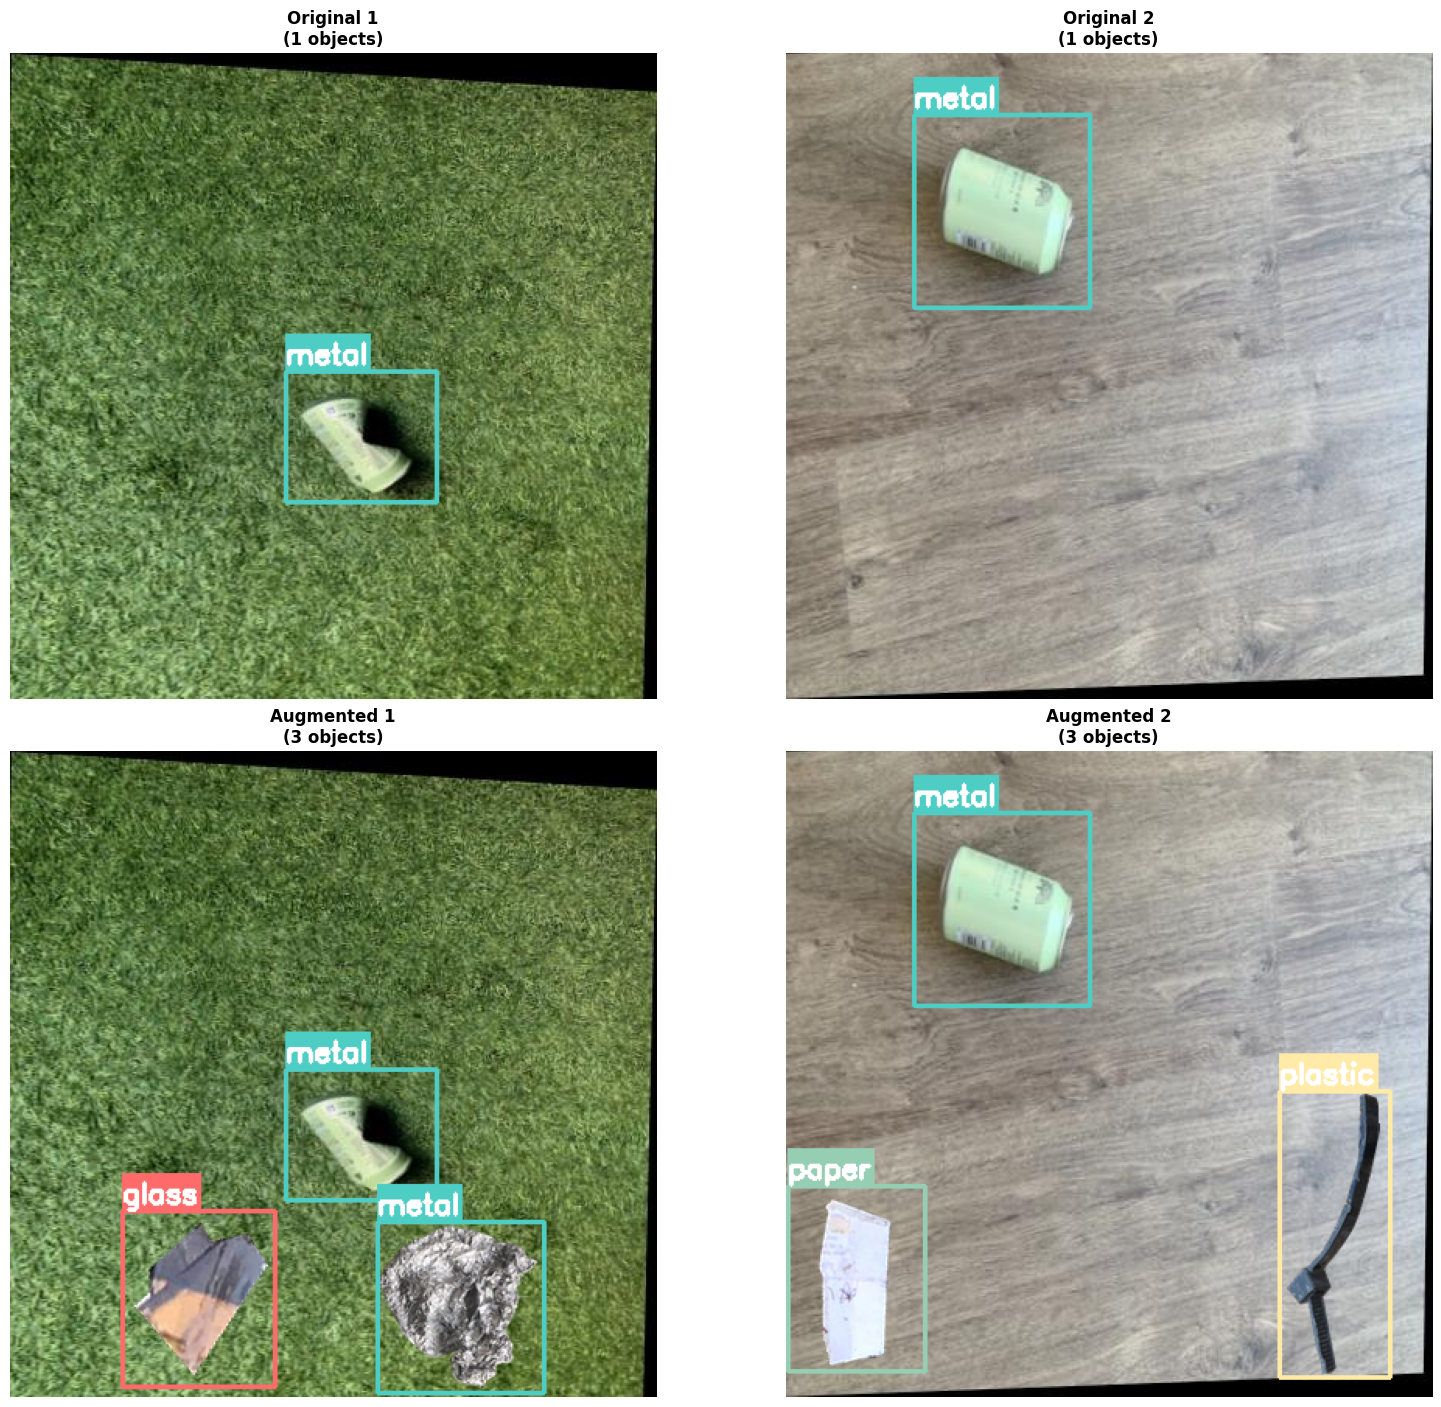


🎨 Creating synthetic images figure...
✅ Synthetic images figure saved:
   📄 PNG: paper_synthetic_images_figure.png
   📄 PDF: paper_synthetic_images_figure.pdf


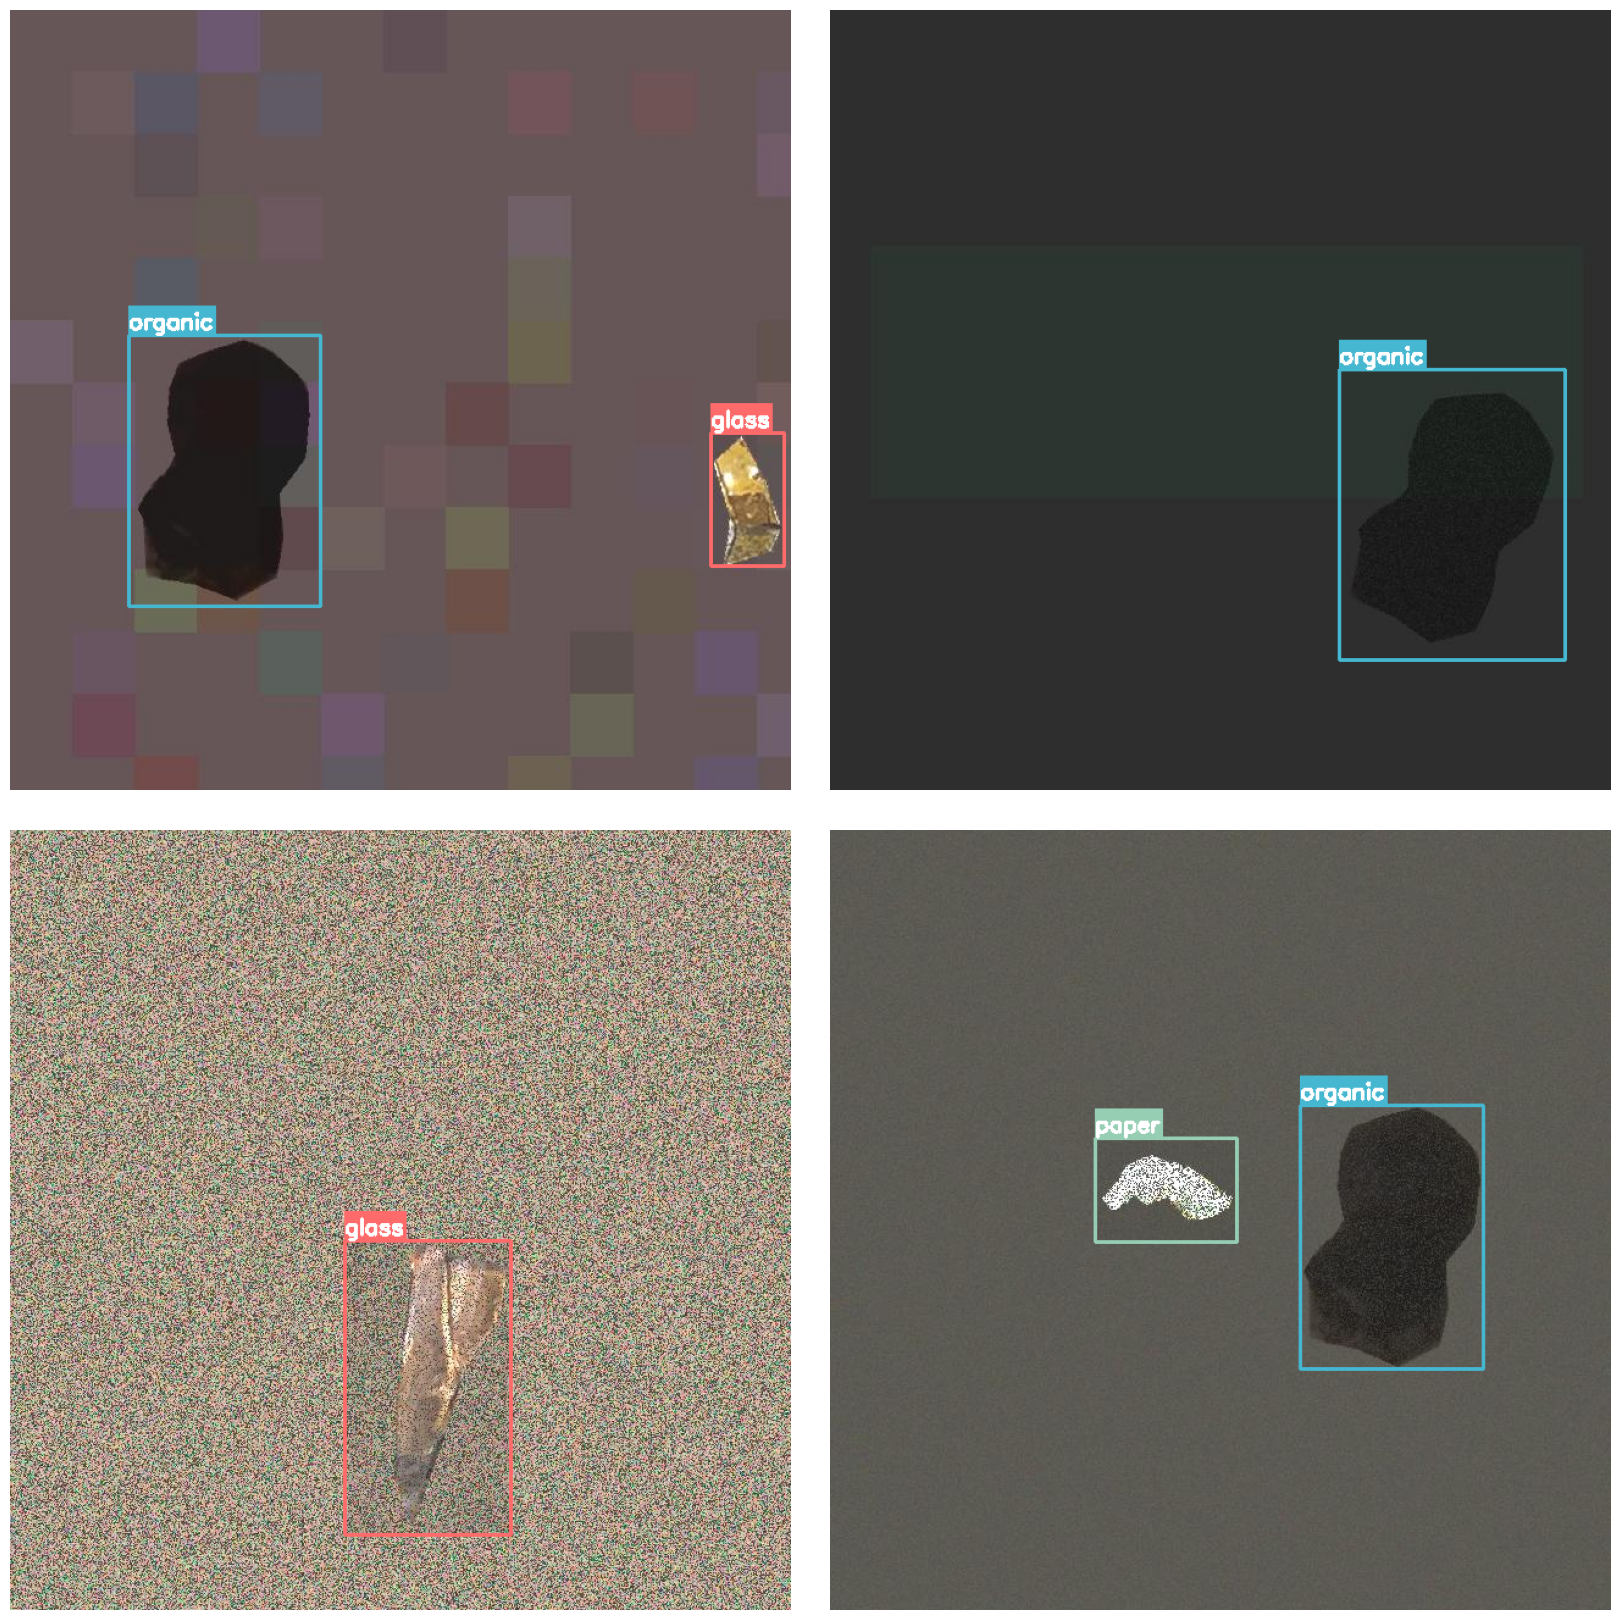


🎉 Paper Figure Generation Complete!
📄 High-resolution figures saved for publication
📊 Resolution: 300 DPI
📐 Size: 16x16 inches


In [6]:
# =====================================================
# GENERATE PAPER FIGURES
# =====================================================

print("🎨 Starting Paper Figure Generation...")
print("=" * 50)

# Load object bank
print("📦 Loading object bank...")
object_bank = load_object_bank()

if not any(object_bank.values()):
    print("❌ Object bank is empty. Please run synthetic data generation first.")
else:
    print(f"✅ Object bank loaded with {sum(len(objs) for objs in object_bank.values())} total objects")
    
    # Find suitable training images for augmentation
    print("\n🔍 Finding suitable training images for augmentation...")
    suitable_images = find_suitable_training_images(K_FOLD_CV_DIR, num_images=4)
    
    if suitable_images:
        print(f"✅ Found {len(suitable_images)} suitable images")
        
        # Generate augmented images figure
        print("\n🎨 Creating augmented images figure...")
        augmented_fig = create_augmented_images_figure(suitable_images, object_bank)
        
        if augmented_fig:
            # Save the figure
            augmented_filename = 'paper_augmented_images_figure.png'
            augmented_fig.savefig(augmented_filename, dpi=FIGURE_DPI, 
                                bbox_inches='tight', facecolor='white', 
                                edgecolor='none', pad_inches=0.2)
            
            augmented_pdf = 'paper_augmented_images_figure.pdf'
            augmented_fig.savefig(augmented_pdf, bbox_inches='tight', 
                                facecolor='white', edgecolor='none', pad_inches=0.2)
            
            print(f"✅ Augmented images figure saved:")
            print(f"   📄 PNG: {augmented_filename}")
            print(f"   📄 PDF: {augmented_pdf}")
            
            plt.show()
        else:
            print("❌ Failed to create augmented images figure")
    else:
        print("⚠️ No suitable images found for augmentation examples")
    
    # Generate synthetic images figure
    print("\n🎨 Creating synthetic images figure...")
    synthetic_fig = create_synthetic_images_figure(object_bank)
    
    if synthetic_fig:
        # Save the figure
        synthetic_filename = 'paper_synthetic_images_figure.png'
        synthetic_fig.savefig(synthetic_filename, dpi=FIGURE_DPI, 
                            bbox_inches='tight', facecolor='white', 
                            edgecolor='none', pad_inches=0.2)
        
        synthetic_pdf = 'paper_synthetic_images_figure.pdf'
        synthetic_fig.savefig(synthetic_pdf, bbox_inches='tight', 
                            facecolor='white', edgecolor='none', pad_inches=0.2)
        
        print(f"✅ Synthetic images figure saved:")
        print(f"   📄 PNG: {synthetic_filename}")
        print(f"   📄 PDF: {synthetic_pdf}")
        
        plt.show()
    else:
        print("❌ Failed to create synthetic images figure")

print("\n" + "=" * 50)
print("🎉 Paper Figure Generation Complete!")
print("📄 High-resolution figures saved for publication")
print(f"📊 Resolution: {FIGURE_DPI} DPI")
print(f"📐 Size: {FIGURE_SIZE[0]}x{FIGURE_SIZE[1]} inches")